In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

import os
from datetime import datetime

In [2]:
# assign path
path, dirs, files = next(os.walk("data/halfhourly_dataset/"))
file_count = len(files)
# create empty list
df_list = []

#blocks with problems: 51 12 33 13 19 108 9
files = ["block_0.csv", "block_1.csv", "block_2.csv"]
file_count = 3

# append datasets to the list 
for i in range(file_count):
    temp_df = pd.read_csv("data/halfhourly_dataset/"+files[i], low_memory=False)
    df_list.append(temp_df)
    
df = pd.concat(df_list)

#read weather file
df_weather = pd.read_csv("data/weather_daily_darksky.csv", low_memory=False)


In [3]:
#Remover Nulls
df = df.dropna()

In [4]:
df.columns = ['house', 'time', 'energy']

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df_weather['temperatureMaxTime'] = pd.to_datetime(df_weather['temperatureMaxTime'], errors='coerce')

#We will work with only the year 2013 to make things easier
df = df[df['time'].dt.isocalendar().year == 2013]
df = df[df['time'].dt.strftime('%Y-%m-%d') != '2012-12-31']
df_weather = df_weather[df_weather['temperatureMaxTime'].dt.isocalendar().year == 2013]
df_weather = df_weather[df_weather['temperatureMaxTime'].dt.strftime('%Y-%m-%d') != '2012-12-31']

df['house'] = df['house'].astype(str)
df['energy'] = pd.to_numeric(df['energy'], errors='coerce')

In [5]:
#print(df.describe(include = 'all', datetime_is_numeric=True))


<AxesSubplot:xlabel='time'>

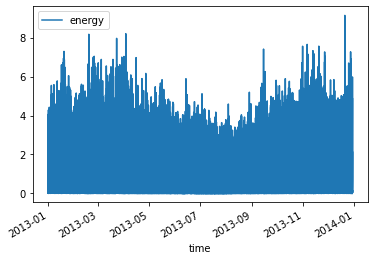

In [6]:
df.plot(x='time', y='energy')

In [7]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['time'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [8]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['time'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [9]:
# time with int to plot easily
df['time_epoch'] = (df['time'].astype(np.int64)/100000000000).astype(np.int64)

In [10]:
# creation of 4 distinct categories
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0] # WeekEnd Night
b = df.loc[df['categories'] == 1] # WeekEnd Day
c = df.loc[df['categories'] == 2] # WeekDay Night
d = df.loc[df['categories'] == 3] # WeekDay Day
#print(a)

a = a.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
b = b.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
c = c.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
d = d.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
#print(a)

a = a.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
b = b.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
c = c.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
d = d.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
#print(a)

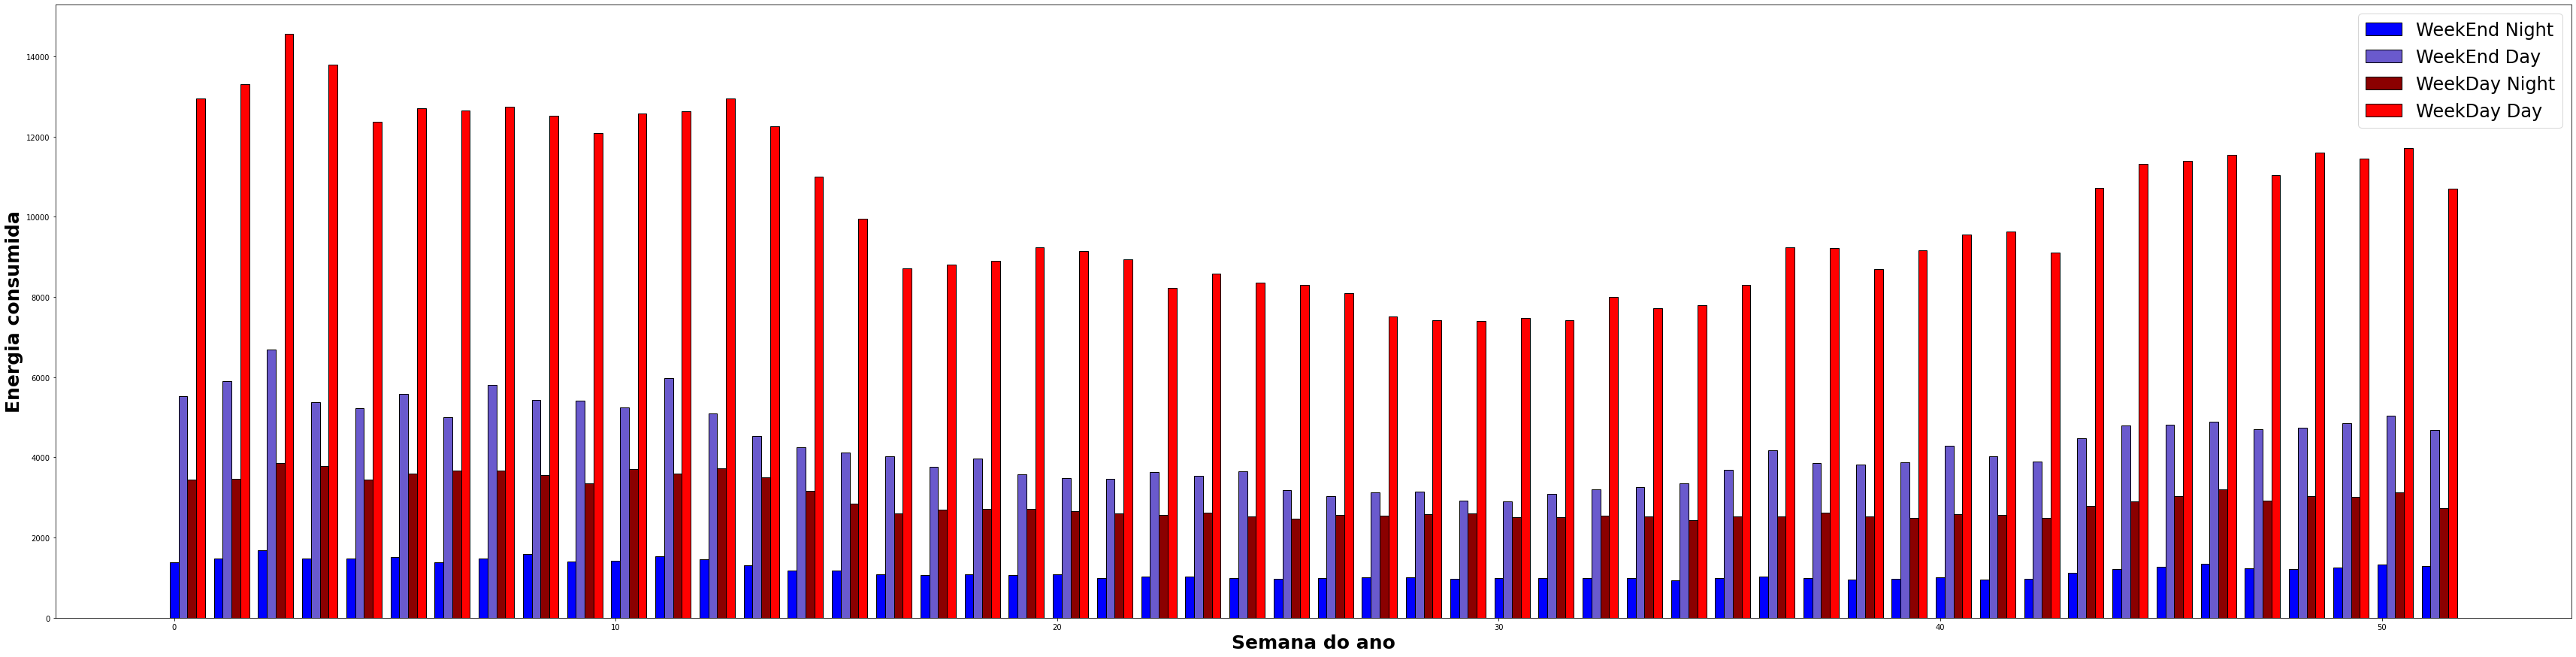

In [11]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(60, 15))

weeks = list(range(1, 52))
label=['WeekEnd Night', 'WeekEnd Day', 'WeekDay Night', 'WeekDay Day']
 
# Set position of bar on X axis
br1 = np.arange(len(a))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, a['energy'], color ='blue', width = barWidth,
        edgecolor ='black', label ='WeekEnd Night')

plt.bar(br2, b['energy'], color ='slateblue', width = barWidth,
        edgecolor ='black', label ='WeekEnd Day')

plt.bar(br3, c['energy'], color ='darkred', width = barWidth,
        edgecolor ='black', label ='WeekDay Night')

plt.bar(br4, d['energy'], color ='red', width = barWidth,
        edgecolor ='black', label ='WeekDay Day')
 
# Adding Xticks
plt.xlabel('Semana do ano', fontweight ='bold', fontsize = 25)
plt.ylabel('Energia consumida', fontweight ='bold', fontsize = 25)
#plt.xticks([r + barWidth for r in range(len(a))],
#        weeks)
 
plt.legend(loc='upper right', prop={'size': 24})
plt.show()
#lux mais cara durante o dia
#grafico preço e gasto depois

In [12]:
#usar temp média
dft = df.groupby(['house', pd.Grouper(key='time', freq='D')])['energy'].sum().reset_index().sort_values(['house', 'time'])
dft = dft.groupby(['time'])['energy'].sum().reset_index().sort_values('time')

#maybe fazer isto mais cedo?
df_weather['temperatureMaxTime'] = pd.to_datetime(df_weather['temperatureMaxTime']).dt.date
dft['time'] = pd.to_datetime(dft['time']).dt.date

dft = dft.merge((df_weather.iloc[:,[0,1]]), left_on='time', right_on='temperatureMaxTime')
dft = dft.iloc[:,[0,1,2]]
print(dft)

           time       energy  temperatureMax
0    2013-01-01  3420.095998            7.49
1    2013-01-02  3365.991000           10.82
2    2013-01-03  3148.651001           11.41
3    2013-01-04  3142.730999           10.79
4    2013-01-05  3356.867999           10.66
..          ...          ...             ...
358  2013-12-25  3642.939000            7.19
359  2013-12-26  3491.808999            7.64
360  2013-12-27  3168.927999           10.99
361  2013-12-28  2930.288002            7.81
362  2013-12-29  3046.942003            7.56

[363 rows x 3 columns]


<AxesSubplot:xlabel='temperatureMax'>

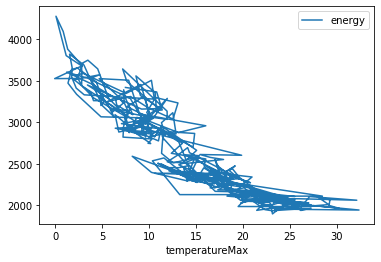

In [13]:
dft.plot(x='temperatureMax', y='energy')
#mais frio mais energia se gasta